# Part II - (Loans Data Set Exploratory)
## by (Salih Alborno)

## Investigation Overview

I have carried out a comprehensive data analysis of the loans company data, which inclucded a large number of visulisation in trying to glean insights and uncover relationships between some of the many variables found in the data set. This notebook presents a select number of key findings and visulisations in a presentation deck style.

The purpose of this presentation is to show trends related to expected returns back from loans, how they vary accordiing to different loan types, and what may impact tho value of returns back to lenders:


 
- The loan company made changes over time, where 36 month term loans were offered first, then 12 months and 60 months term loans were introduced in Nov 2010.

- Debt Consolidation was found to be the most popular loan category by large, followed by Home Improvement and Business categories.

- 12 months loans were found to be less profitable than 36 months and 60 months term loans and were stopped in Apr 2013.

- Lenderyield and EstimatedRetrun are found to increase as ProsperRating (Alpha) and ProsperScore worsened. A large number of Hight Risk loans (HR) were at 0.3 LenderYield.

- EstimatedLoss and EstimatedEffectiveYield are found to have changed over time, where in 2009-2010 were calcualted based on fixed offset values assigned according to ProsperRating (Alpha) and ProsperScore levels. Since then, the offset seems to have been depricated, in favour of a more direct linear relationship.  

- Average Estimated Return reached its highest value (0.115) in 2011, but declined since then to reach its lowest ever value (0.072) in 2014.


## Dataset Overview

The data set contains 113,937 loans with 81 variables representing features collected on those given loans, such as loan amount, borrower rate (or interest rate), current loan status, borrower income, borower rate, estimated return, effective yield, and many more.

The dataset is divided into two periods; pre Jul 2009 and post Jul 2009. This analysis focuses on post Jul 2009. This is because post Jul 2009 data set includes extra set of metrics such as Estimated Return, and Estimated Loss and using various borrower scoring and ratings algorithms which can help in loan analysis. Also post Jul 2009 data set is a much longer period spanning 6 years vs 2 years for pre Jul 2009 period.

In [2]:
# import all packages and set plots to be embedded inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
## Important ##
# hack needed for statsmodels 0.12.x to allow patchworklib to work. If statsmodels version is 0.13.2, this is not needed

import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered



In [4]:
# load patchworklib now

import patchworklib as pw


<Figure size 72x72 with 0 Axes>

In [5]:
# load in the dataset into a pandas dataframe

dfc = pd.read_csv('./uda_data/prosperLoanData.csv')


In [6]:
## Clean ##
##   2   ##

# which are the popular categories loans are taken for?
# lets convert the loan category numbers into their actual names for user friendleness and ease of understanding plots.

cat_dict = {0: 'Not Available', 1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 
            4: 'Personal Loan', 5: 'Student Use', 6: 'Auto', 7: 'Other', 8: 'Baby&Adoption', 9: 'Boat', 
            10: 'Cosmetic Procedure', 11: 'Engagement Ring', 12: 'Green Loans', 13: 'Household Expenses', 
            14: 'Large Purchases', 15: 'Medical/Dental', 16: 'Motorcycle', 17:'RV', 18:'Taxes', 19:'Vacation', 20: 'Wedding Loans'}

dfc['ListingCategory'] = dfc['ListingCategory (numeric)'].map(cat_dict)

In [7]:
## Clean ##
##   3   ##

# convert date string to date object to work with.
dfc['LoanDate'] = pd.to_datetime(dfc['LoanOriginationDate'].str.split(' ', n=1, expand = True)[0], format='%Y-%m-%d')
dfc['year'] = dfc['LoanDate'].map(lambda x: x.strftime('%Y'))

In [8]:
## Clean ##
##   4   ##

# convert some variables into ordered categorical types so that they appear in a logical order during analysis and when plotting:
def sort_categorical_vars():
    
    ordinal_var_dict = {'LoanStatus': ['Completed', 'Current', 'Defaulted', 'Chargedoff', 'Cancelled', 'FinalPaymentInProgress', 
                                       'Past Due (1-15 days)', 'Past Due (16-30 days)', 'Past Due (31-60 days)', 
                                       'Past Due (61-90 days)', 'Past Due (91-120 days)', 'Past Due (>120 days)'],
                        'CreditGrade': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC'],
                        'ProsperRating (Alpha)': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR'],
                        'IncomeRange': ['$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', '$75,000-99,999', '$100,000+', 'Not employed', 'Not displayed'],
                        'year': ['2006','2007','2008','2009','2010','2011','2012','2013','2014']
                        #'col2': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
                       }
    
    for var in ordinal_var_dict:
        pd_ver = pd.__version__.split(".")
        if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # v0.21 or later
            ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                        categories = ordinal_var_dict[var])
            dfc[var] = dfc[var].astype(ordered_var)
        else: # pre-v0.21
            dfc[var] = dfc[var].astype('category', ordered = True,
                                                 categories = ordinal_var_dict[var])

sort_categorical_vars()

In [9]:
## Clean ##
##   5   ##

# NaNs analysis revealed that we need to treat pre and post Jul 2009 data observations differently.
# let's define a day to cut the dataframe with

from datetime import datetime

# define split dates
d2009Jan = datetime(2009, 1, 1 )
d2009Aug = datetime(2009, 8, 1 )
#print(d2009Jan, '<->', d2009Aug)

# add extra categorical column for differentiating the two datasets in the amin dfc
dfc['period'] = np.where(dfc['LoanDate'] >= d2009Aug, 'post-Jul2009', 'pre-Jul2009')

# lets slice the dataframe into two datasets, one for the period upto Dec 2008, and another for the period starting Aug 2009
# This will help us keep the analysis meaningful and metrics consistent as we go along.

dfc_new = dfc.loc[dfc['LoanDate'] >= d2009Aug,:].copy()
dfc_old = dfc.loc[dfc['LoanDate'] < d2009Jan,:].copy()

In [10]:
## Clean ##
##   6   ##

dfc_new['yearSplit'] = np.where((dfc_new['year'] == '2009') | (dfc_new['year'] == '2010'), '2009-2010', '2011-2014')
# dfc_new.groupby(['yearSplit'])['year'].value_counts()
# dfc_new['year'].value_counts()

In [11]:
## Clean ##
##   7   ##

# Need to resort dfc['year'] to remove years from pre Jul 2009 data, given it does not have our metrics of interest (LenderReturn and EstimatedEffectiveYield)
# So that we avoid the palette wrong number of colours error in the next plot, which uses dfc_new dataframe for post Jul 2009 loans only.

# convert some variables into ordered categorical types so that they appear in a logical order during analysis and when plotting:
def sort_categorical_vars_post_jul2009():
    
    ordinal_var_dict = {
                        'year': ['2009','2010','2011','2012','2013','2014']
                        #'col2': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
                       }
    
    for var in ordinal_var_dict:
        pd_ver = pd.__version__.split(".")
        if (int(pd_ver[0]) > 0) or (int(pd_ver[1]) >= 21): # pandas v0.21 or later
            ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                        categories = ordinal_var_dict[var])
            dfc_new[var] = dfc_new[var].astype(ordered_var)
        else: # pandas pre-v0.21
            dfc_new[var] = dfc_new[var].astype('category', ordered = True,
                                                 categories = ordinal_var_dict[var])

sort_categorical_vars_post_jul2009()
# dfc_new['year'].value_counts()

In [12]:
## Clean ##
##   8   ##

# What is the average EstimatedReturn per year? and does it show any change over time?

# Calculate mean and median per year ready for plotting later

grouped = dfc_new.groupby(['year']).agg({'EstimatedReturn':[np.mean, np.median]}).reset_index()
grouped.columns = ['_'.join(tup).rstrip('_') for tup in grouped.columns.values]
#grouped

## Focusing on post Jul 2009 data

- Examining the data set revealed that post Jul 2009 have rich set of metrics such as Estimated Return, Estimated Effective yield and Estimated Loss and have various borrower scoring and ratings scales used in loan analysis when compared to compared to pre Jul 2009 data.

- Also, pre Jul 2009 data covers a shorter span than post Jul 2009, where post Jul 2009 data set covers 6 years vs 2 years for pre Jul 2009 data set. 

- Therefore, our analysis will focus on the post Jul 2009 data set to glean relationships and insights on loan metrics used for determining rates and ROI.

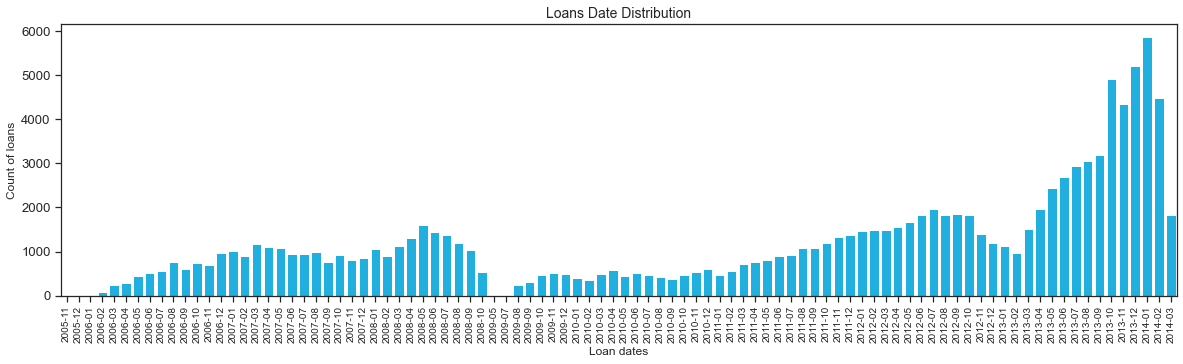

In [50]:
# let's look at the date distribution for the loans data set.
# we can see a gap in the middle splitting the data into two periods, 
# Some metrics are only present in one of the periods but not the other. Looks like some metrics are removed and some new ones
# are introduced in the second period starting Aug2008.

plt.figure(figsize=(20,5))

# get year_month values for ease of plotting timeline in ordered consistent manner: 
dfc['y_m'] = dfc['LoanDate'].map(lambda x: x.strftime('%Y-%m'))

grid = sns.countplot(data=dfc.sort_values(by=['y_m']), x='y_m', color='deepskyblue')
grid.tick_params(axis='x', labelrotation=90, labelsize=10)
grid.set_title('Loans Date Distribution', fontsize=14)
grid.set_xlabel("Loan dates", fontsize=12)
grid.set_ylabel("Count of loans", fontsize=12);


## Loan Terms by Year

- The data shows that 36 months loans have been since the begining, however 12 months and 60 months loans were introduced in Nov 2010.

- While 60 months loans continued to 2014, 12 months loans seem to have been stopped in Apr 2013.

- This, again, confirms that focusing on Post Jul 2009 data for this analysis of data is more sensible.


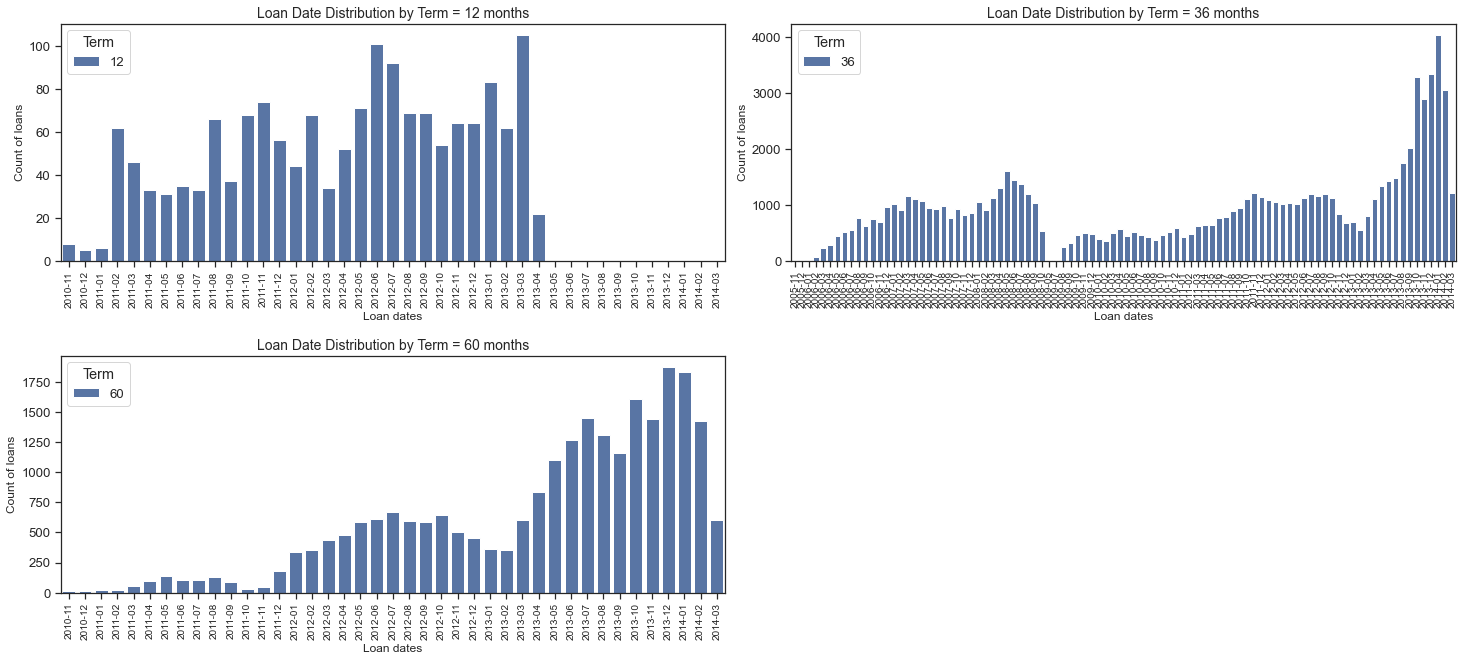

In [51]:
## let's look further at the Term distribution for loans

# We can see that the 12 months term loans have been introduced at the same time as 60 months term loans Nov. 2010, 
# but the 12 months term loans only present in the data until in Apr. 2013
# has the 12 months term loans been discontinued? or are there missing data?

plt.figure(figsize = [25, 10])
plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=0.4, wspace=0.1) #control gap between subplots
palette = sns.color_palette("deep", 3) #Paired

dfc['y_m'] = dfc['LoanDate'].dt.strftime('%Y-%m')

ax3 = plt.subplot(2, 2, 3)
grid = sns.countplot(data=dfc[dfc['Term'] == 60].sort_values(by='y_m'), x='y_m', hue='Term')#, palette=palette
grid.tick_params(axis='x', labelrotation=90, labelsize=10)
grid.set_title("Loan Date Distribution by Term = 60 months", fontsize=14)
grid.set_xlabel("Loan dates", fontsize=12)
grid.set_ylabel("Count of Loans", fontsize=12)
sns.move_legend(grid, "upper left", bbox_to_anchor=(0, 1));

ax1 = plt.subplot(2, 2, 1)
grid = sns.countplot(data=dfc[dfc['Term'] == 12].sort_values(by='y_m'), x='y_m', hue='Term')#, palette=palette
grid.tick_params(axis='x', labelrotation=90, labelsize=10)
grid.set_title("Loan Date Distribution by Term = 12 months", fontsize=14)
grid.set_xlabel("Loan dates", fontsize=12)
grid.set_ylabel("Count of Loans", fontsize=12)
sns.move_legend(grid, "upper left", bbox_to_anchor=(0, 1));
ax1.sharex(ax3) # make 12 and 60 plots share x-axis to show start and end points

ax2 = plt.subplot(2, 2, 2)
grid = sns.countplot(data=dfc[dfc['Term'] == 36].sort_values(by='y_m'), x='y_m', hue='Term')#, palette=palette
grid.tick_params(axis='x', labelrotation=90, labelsize=10)
grid.set_title("Loan Date Distribution by Term = 36 months", fontsize=14)
grid.set_xlabel("Loan dates", fontsize=12)
grid.set_ylabel("Count of Loans", fontsize=12)
sns.move_legend(grid, "upper left", bbox_to_anchor=(0, 1));


## LenderYield vs EstimatedReturn

- EstimatedReturn have narrow spread of values, when compared to LenderYield values have wider spread of values when compared to EstimatedReturn.

- 12 months term loans are found to be less profitable than 36 and 60 months term loans.

- 36 months term loans are found to have some loans with negative EstimatedReturn, which is not the case 12 and 60 months term loans.

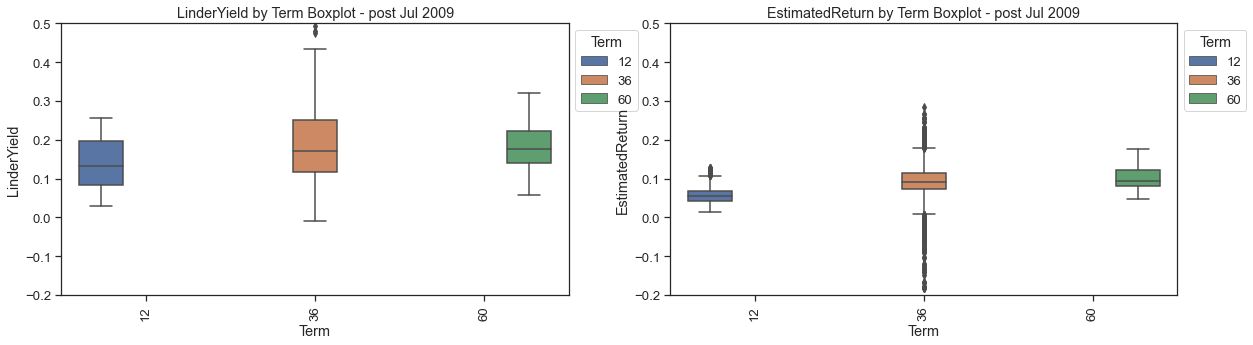

In [52]:
# lets see how LinderYield varies per category for pre and post Jul 2009 data sets in one plot

# The plot shows that that post-Jul 2009 loans have higher LinderYields compared to pre-Jul 2009 loans

plt.figure(figsize=(20,5))
# Use white grid plot background from seaborn
#sns.set(font_scale=1.2, style="ticks")
# sns.set_theme() # reset to default

plt.subplot(1, 2, 1)
grid = sns.boxplot(data=dfc, y='LenderYield', x='Term', hue='Term')
grid.set_ylim([-0.2,0.5])
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('LinderYield by Term Boxplot - post Jul 2009')
grid.set(xlabel='Term', ylabel='LinderYield');
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1));

plt.subplot(1, 2, 2)
grid = sns.boxplot(data=dfc, y='EstimatedReturn', x='Term', hue='Term')
grid.set_ylim([-0.2,0.5])
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('EstimatedReturn by Term Boxplot - post Jul 2009')
grid.set(xlabel='Term', ylabel='EstimatedReturn');
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1));

## Loan Categories

- Debt Consolidation is the most popular loan category by a large degree.

- Ignoring "Other", Home Improvement and Business are the next two most popular loan categories consecutively.

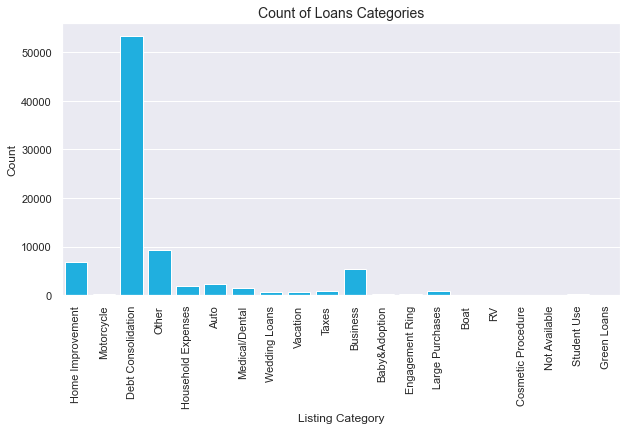

In [40]:
# Let's examine the distribution of loan Categories, where I suspect there will be important variations that influences trends in data

# Debt Consolidation is by a large margin is the most dominant loan category.
# Not Available and Other are the second most common classifications, which surprising. Also, what is the difference between them?
# Home Improvement and Business are also a bit more popular than other cateogires
plt.rcParams["figure.figsize"] = (10,5)

grid = sns.countplot(x=dfc_new['ListingCategory'], color='deepskyblue')
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('Count of Loans Categories', fontsize=14)
grid.set(xlabel='Listing Category', ylabel='Count');

## Prosper Rating (Alpha) influence on LenderYield

- LenderYield are found to increase as the ProsperRating (Alpha) worsened.

- A large number of High Risk (HR) Loans are shown to have LenderYield at 0.3 causing a large peak to appear at 0.3 in the LenderYield Histogram plot.


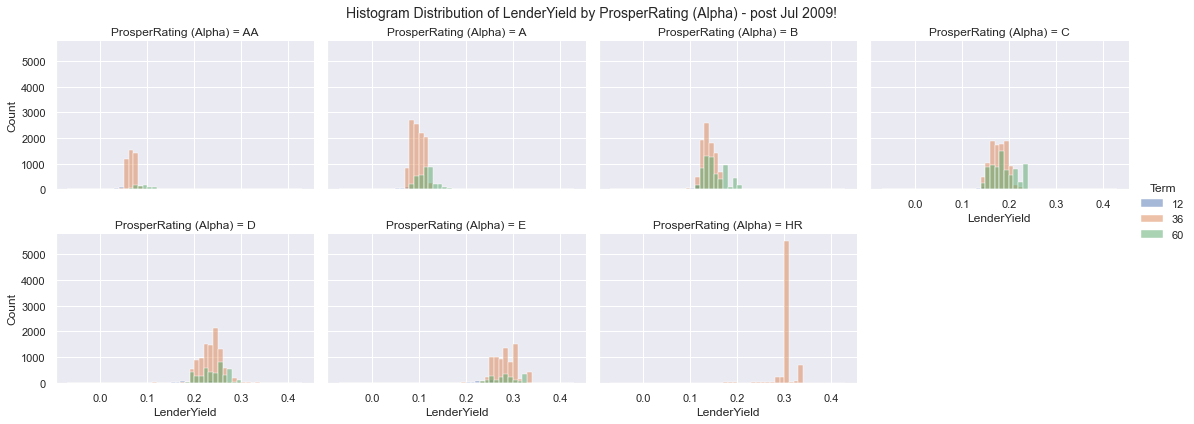

In [35]:
# How does LenderYield for post Jul 2009 vary according to ProsperRating (Alpha) and Term?

# The plots here revealed that the 0.3 high peak is very strongly associated with loans given to individuals who are identified High Risk (HR) and to a smaller degree to level E.
# Also, this plots shows that ProsperRating (Alpha) have a very strong influence on LenderYiled levels, where LenderYield increases as the ProsperRating (Alpha) decreases

plt.rcParams["figure.figsize"] = (15,10) #stops <Figure size 1080x720 with 0 Axes> from printing when usingplt.figure(figsize = [15, 10])

bins = np.arange(dfc_new['LenderYield'].min()-0.1,dfc_new['LenderYield'].max()+0.1,0.01)
#plt.figure(figsize = [20, 10])
# plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=.5, wspace=0.2) #control gap between subplots
sns.set(font_scale=1) # change plots individual title size.
grid = sns.FacetGrid(data=dfc_new, col='ProsperRating (Alpha)', hue='Term', col_wrap=4, margin_titles=True, height=3, aspect= 1.33)# control facitgrid graph widths: margin_titles=True, height=3, aspect= 1.33
grid.map(sns.histplot, 'LenderYield', bins=bins, alpha=0.5); # remove binwidth if you want auto generated different bin widths for each plot.
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('Histogram Distribution of LenderYield by ProsperRating (Alpha) - post Jul 2009!', fontsize=14);
grid.add_legend();

## ProsperRating (Alpha) influence on EstimatedReturn

- EstimatedReturn are found to also increase as the ProsperRating (Alpha) worsened.


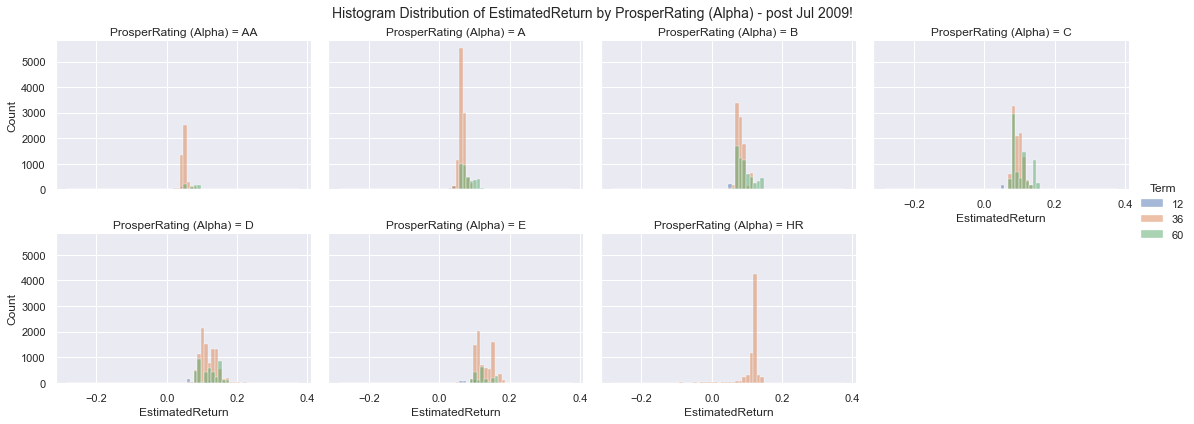

In [34]:
# How does LenderYield for post Jul 2009 vary according to ProsperRating (Alpha) and Term?

# The plots here revealed that the 0.3 high peak is very strongly associated with loans given to individuals who are identified High Risk (HR) and to a smaller degree to level E.
# Also, this plots shows that ProsperRating (Alpha) have a very strong influence on LenderYiled levels, where LenderYield increases as the ProsperRating (Alpha) decreases

plt.rcParams["figure.figsize"] = (15,10) #stops <Figure size 1080x720 with 0 Axes> from printing when usingplt.figure(figsize = [15, 10])

bins = np.arange(dfc_new['EstimatedReturn'].min()-0.1,dfc_new['EstimatedReturn'].max()+0.1,0.01)
#plt.figure(figsize = [20, 10])
# plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=.5, wspace=0.2) #control gap between subplots
sns.set(font_scale=1) # change plots individual title size.
grid = sns.FacetGrid(data=dfc_new, col='ProsperRating (Alpha)', hue='Term', col_wrap=4, margin_titles=True, height=3, aspect= 1.33)# control facitgrid graph widths: margin_titles=True, height=3, aspect= 1.33
grid.map(sns.histplot, 'EstimatedReturn', bins=bins, alpha=0.5); # remove binwidth if you want auto generated different bin widths for each plot.
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('Histogram Distribution of EstimatedReturn by ProsperRating (Alpha) - post Jul 2009!', fontsize=14);
grid.add_legend();

## High Risk Loans Anomality

- High Risk Loans are all found to be be awarded 30 months terms only


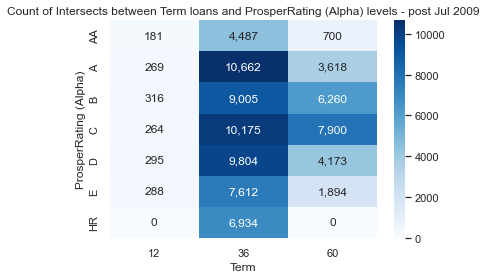

In [70]:
# What is the relationship between Terms of contract (Contract Length) and ProsperRating (Alpha)?

# We can see borrowers flaged with high risk (HR) are only awarded 36 months Term loans
# Also highest number of loans awarded are to borrowers with ProsperRating (Alpha) between A-E for 36 months Term.
# And the second highest number of loans awarded are to borrowers with ProsperRating (Alpha) between B-C for 60 months Term.

dfc_new = dfc_new.loc[:,~dfc_new.columns.duplicated()].copy()
tabular = dfc_new.pivot_table(values='MemberKey', index=['ProsperRating (Alpha)'], columns=['Term'], aggfunc='count', fill_value=0)
#tabular
grid = sns.heatmap(tabular, annot=True, cmap='Blues', fmt=',d')
grid.set_title('Count of Intersects between Term loans and ProsperRating (Alpha) levels - post Jul 2009');

## LenderYield by Category

- All Categories are shown to have LenderYield increase as ProsperRating (Alpha) worsens.

- Debit Consolidation Category is by large the most common loan type, followed by much smaller nubmer of loans awarded to Home Improvement and Business categories.

- There are a significant number of uncategorised loans, which are assigned to the category "Other".

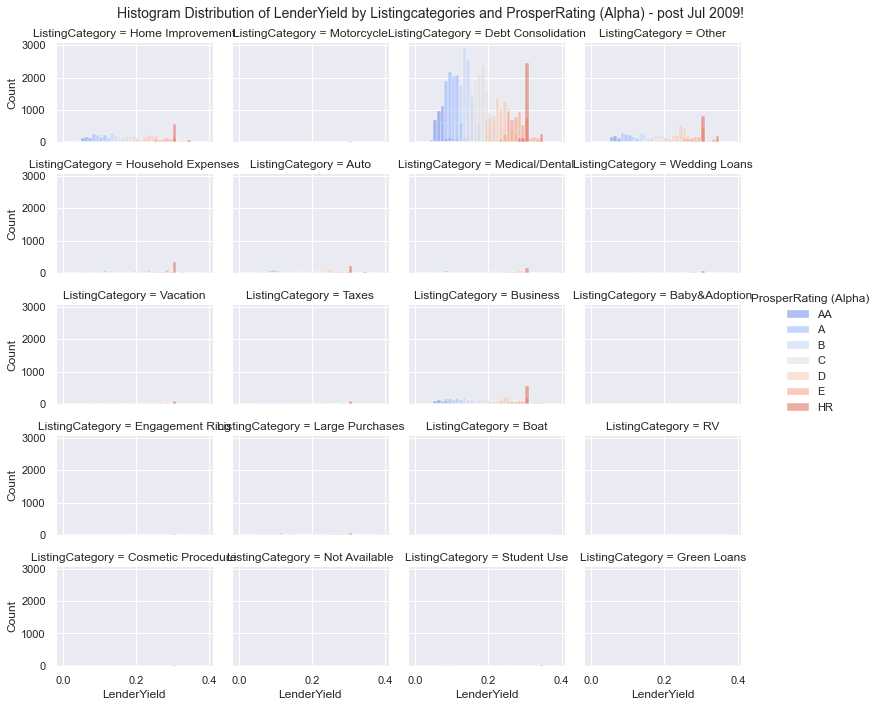

In [30]:
# Given our finding above, let's finally look at how does LenderYield for post Jul 2009 vary according to ListingCategory and 'ProsperRating (Alpha)'? 

# The very same trend of LenderYield increasing as CreditGrade or CreditScoreRangeLower decreased in pre Jul 2009 data is noticable again here. 
# LenderYield increases as ProsperRating (Alpha) decreased in the scale. This is observed in the Blue occupying the left hand side and then
# moving in the colour scale towards Orange on the right hand side. This times showing a much more segemented plot between Blue and Orange than previous plots.
# The plots shows again the peak at 0.3 associated with the lower CrediProsperRating (Alpha) rating values HR and E.

plt.rcParams["figure.figsize"] = (15,10) # stops <Figure size 1080x720 with 0 Axes> from printing when usingplt.figure(figsize = [15, 10])

palette = sns.color_palette("coolwarm", 7) # use coolwarm palette to keep lower values marked with orangey/redish colour

bins = np.arange(0,0.4,0.01)
#plt.figure(figsize = [15, 10])
#plt.subplots_adjust(top = 0.7, bottom=0.01, hspace=.5, wspace=0.2) #control gap between subplots
sns.set(font_scale=1) # change plots individual title size.
grid = sns.FacetGrid(data=dfc_new, col='ListingCategory', hue='ProsperRating (Alpha)', col_wrap=4, margin_titles=True, height=2, aspect= 1.33, palette = palette)# control facitgrid graph widths: margin_titles=True, height=3, aspect= 1.33
grid.map(sns.histplot, 'LenderYield', bins=bins, alpha=0.5); # remove binwidth if you want auto generated different bin widths for each plot.
grid.fig.subplots_adjust(top=0.93)
grid.fig.suptitle('Histogram Distribution of LenderYield by Listingcategories and ProsperRating (Alpha) - post Jul 2009!', fontsize=14);
grid.add_legend();

## EstimatedReturn by Category

- All Categories are also shown to have EstimatedReturn increase as ProsperRating (Alpha) worsens.


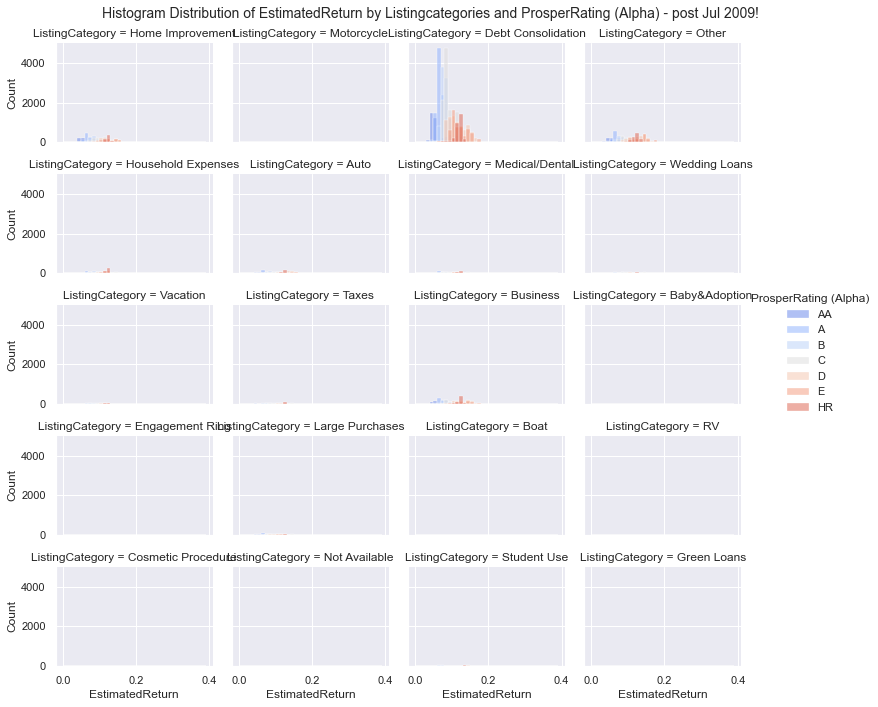

In [27]:
# Given our finding above, let's finally look at how does LenderYield for post Jul 2009 vary according to ListingCategory and 'ProsperRating (Alpha)'? 

# The very same trend of LenderYield increasing as CreditGrade or CreditScoreRangeLower decreased in pre Jul 2009 data is noticable again here. 
# LenderYield increases as ProsperRating (Alpha) decreased in the scale. This is observed in the Blue occupying the left hand side and then
# moving in the colour scale towards Orange on the right hand side. This times showing a much more segemented plot between Blue and Orange than previous plots.
# The plots shows again the peak at 0.3 associated with the lower CrediProsperRating (Alpha) rating values HR and E.
plt.rcParams["figure.figsize"] = (15,10) #stops <Figure size 1080x720 with 0 Axes> from printing when usingplt.figure(figsize = [15, 10])

palette = sns.color_palette("coolwarm", 7) # use coolwarm palette to keep lower values marked with orangey/redish colour

bins = np.arange(0,0.4,0.01)
# plt.figure(figsize = [15, 10])
#plt.subplots_adjust(top = 0.5, bottom=0.01, hspace=.5, wspace=0.2) #control gap between subplots
sns.set(font_scale=1) # change plots individual title size.
grid = sns.FacetGrid(data=dfc_new, col='ListingCategory', hue='ProsperRating (Alpha)', col_wrap=4, margin_titles=True, height=2, aspect= 1.33, palette = palette)# control facitgrid graph widths: margin_titles=True, height=3, aspect= 1.33
grid.map(sns.histplot, 'EstimatedReturn', bins=bins, alpha=0.5); # remove binwidth if you want auto generated different bin widths for each plot.
grid.fig.subplots_adjust(top=0.93)
grid.fig.suptitle('Histogram Distribution of EstimatedReturn by Listingcategories and ProsperRating (Alpha) - post Jul 2009!', fontsize=14);
grid.add_legend();

## ProsperRating (Alpha) Influence on Loan Metrics

- EstimatedLoss is found to be directly related to ProsperRating (Alpha) levels.

- Distinct horizontal plot bands in the EstimatedLoss plot are directly associated with different ProsperRating (Alpha) levels.

- Also groups of diagonal bands of data are correlated with the ProsperRating (Alpha) levels.


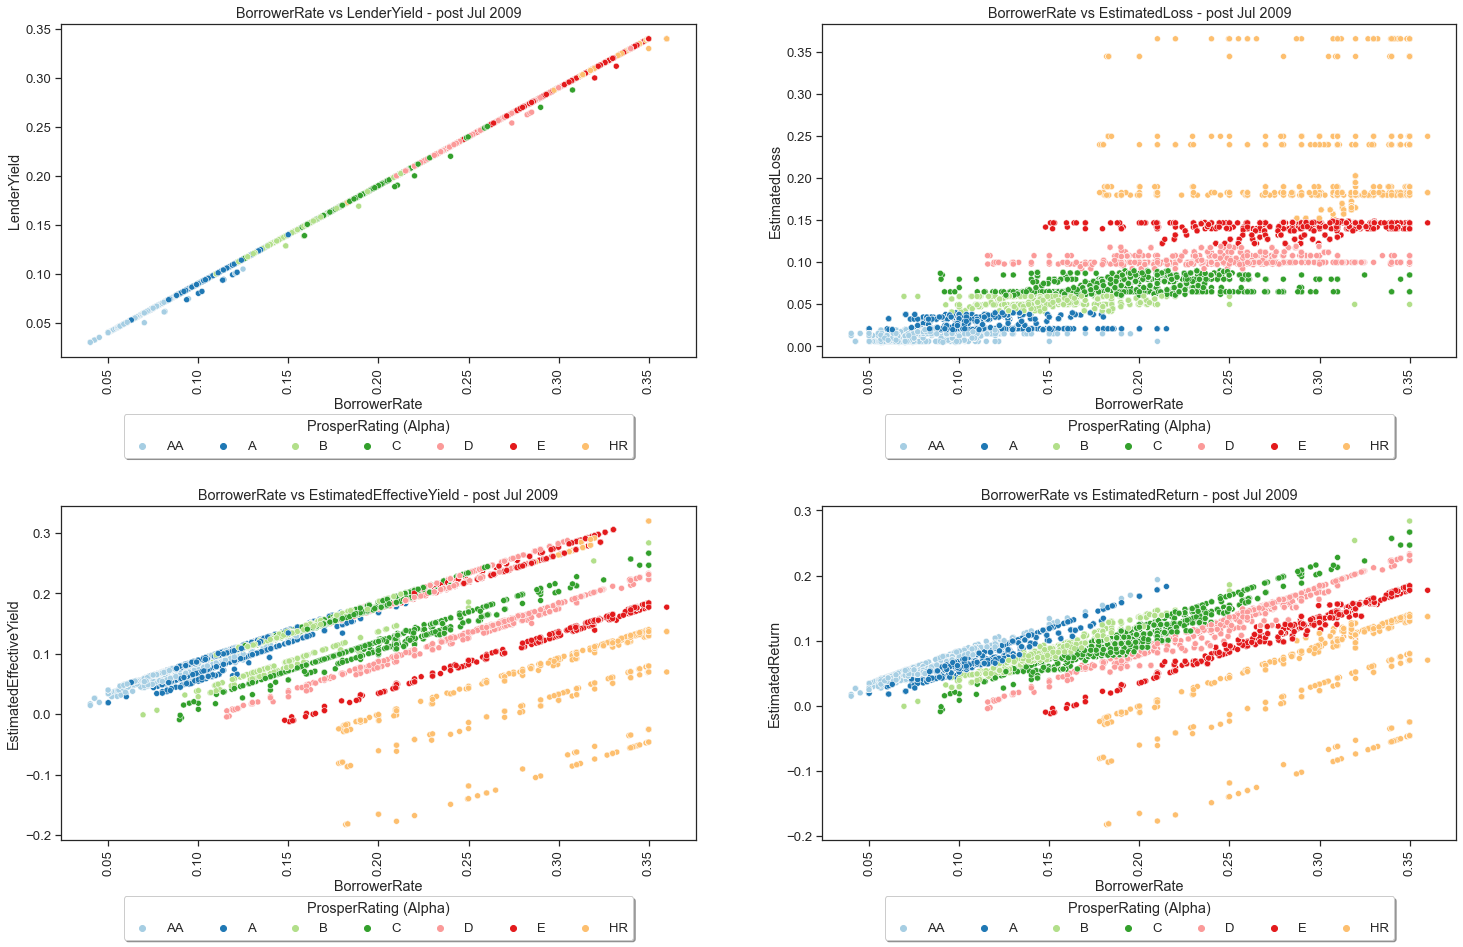

In [58]:
# The relahionship between borrowerRate and EstimateReturn, EstimatedEffectiveYield, and EstimatedLoss shows groups of data points
# What are those groups of data related to?
# lets try to segement the data by ProsperRating (Alpha), which may help explain the different data groupings in the plot too.

# The plot shows that the different ProsperRating (Alpha) ratings explain the different bands observed in our data.

# Also the plots showed that higher ProsperRating (Alpha) has lower EstimatedLoss, higher EstimatedEffectiveYield, and higher EstimatedReturn. 
# Also, As the ProsperRating (Alpha) decreased to lower ratings, the BorrowerRate and EstimatedLoss moved to higher rates, whilest EstimatedEeffectiveYield 
# and EstimatedReturn moved to lower lower rates.

# The plot still shows the presence of sub layers of groupings within those groups that manifests itself by the adjacent parrellel lines within the same colour. 
# What other variables could be contributing to the presence of those sub groups?

plt.figure(figsize = [25, 15])
plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=0.3, wspace=0.2) #control gap between subplots
palette = sns.color_palette("Paired", 7)

# Use white grid plot background from seaborn
sns.set(font_scale=1.2, style="ticks")

plt.subplot(2, 2, 1)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='LenderYield', hue = 'ProsperRating (Alpha)', palette=palette)
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs LenderYield - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='LenderYield');

box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=8, title='ProsperRating (Alpha)')

plt.subplot(2, 2, 2)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedLoss', hue = 'ProsperRating (Alpha)', palette=palette)
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedLoss - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedLoss');

box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=8, title='ProsperRating (Alpha)')

plt.subplot(2, 2, 3)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedEffectiveYield', hue = 'ProsperRating (Alpha)', palette=palette)
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedEffectiveYield - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedEffectiveYield');
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=8, title='ProsperRating (Alpha)')

plt.subplot(2, 2, 4)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedReturn', hue = 'ProsperRating (Alpha)', palette=palette) 
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedReturn - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedReturn');
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=8, title='ProsperRating (Alpha)'); # increase ncol by 1 for title to show


## ProsperScore Influence on Loan Metrics

- ProsperScore is also shown to have a direct influence on EstimatedLoss, EstimatedEffectiveYield, and thus EstimatedReturn.

- The horizontal rows in the EstimatedLoss plot and the diagonal rows in the EstimatedEffectiveYield are found to correspond to ProsperScore levels.


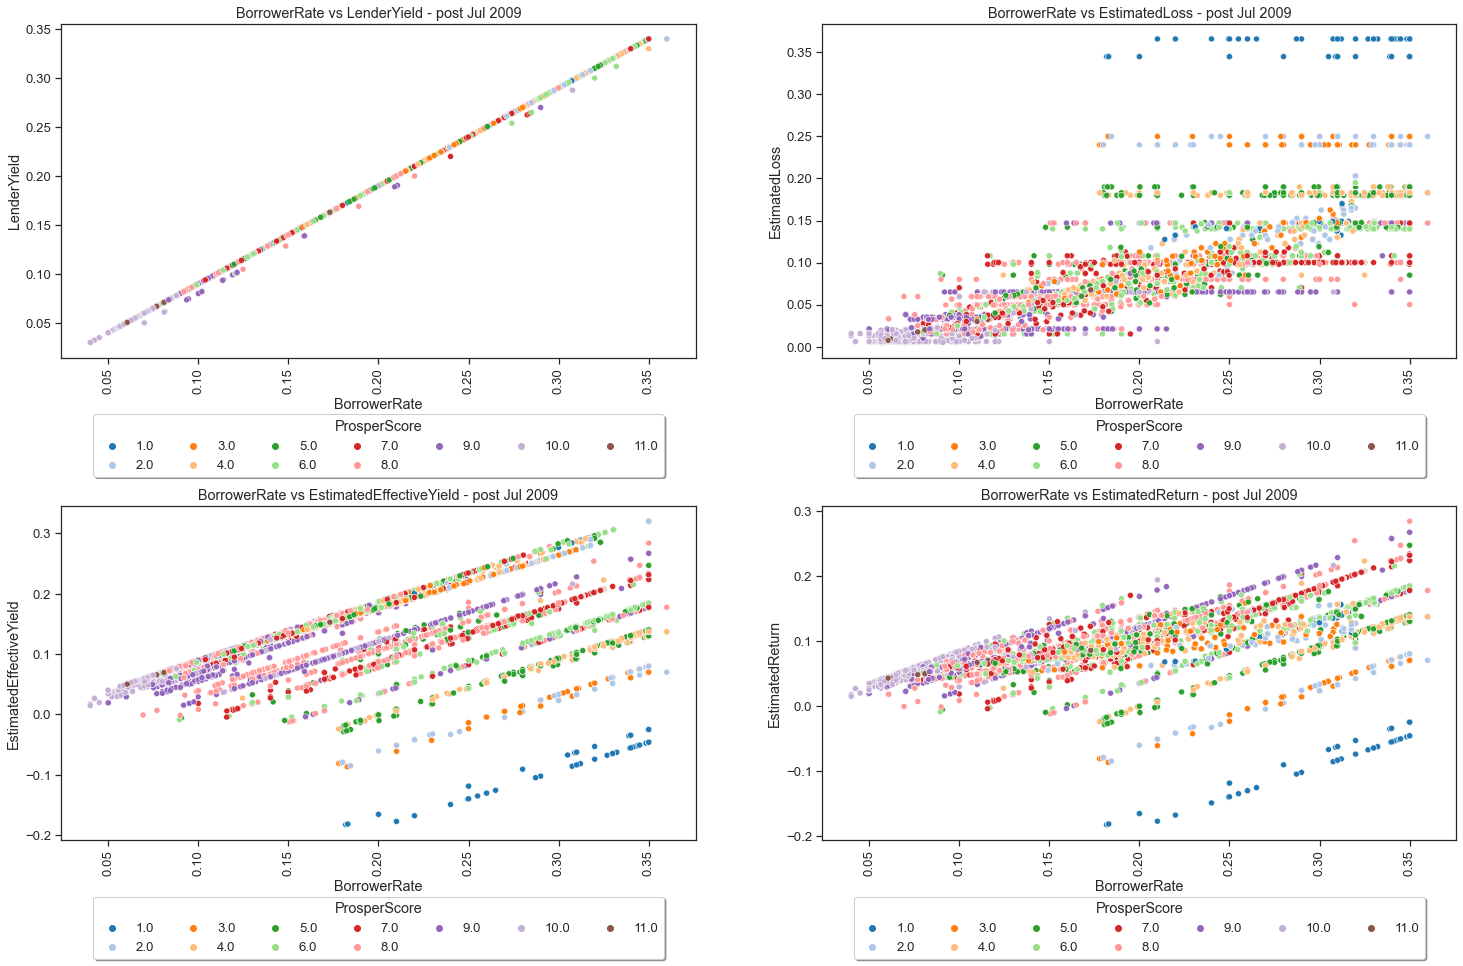

In [59]:
# The relahionship between borrowerRate and EstimateReturn, EstimatedEffectiveYield, and EstimatedLoss shows groups of data points
# What are those groups of data related to?

# lets try to segement the data by ProsperScore to see if also has an impact on how those bands are classified.

# The pattern observed with ProsperRating (Alpha) is repeated here, where "generally speaking" the lowest end of the scale dominates
# one end of the plot, and gradually increasing until reaching the highest end of the scale at the other side of the plot.
# Also, (admittedly it is a bit hard to see!) ignroing the lowest level that takes the blue band by itself, we can see that each two adjacent levels of the ProsperScore 
# dominate one band in the plot generally speaking.
# let's try a divergent palette in the next plot.

plt.figure(figsize = [25, 15])
plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=0.3, wspace=0.2) #control gap between subplots

# Use white grid plot background from seaborn
sns.set(font_scale=1.2, style="ticks")

plt.subplot(2, 2, 1)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='LenderYield', hue = 'ProsperScore', palette="tab20")
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs LenderYield - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='LenderYield');
# Shrink current axis's height by 10% on the bottom
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=7, title='ProsperScore')

plt.subplot(2, 2, 2)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedLoss', hue = 'ProsperScore', palette="tab20")
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedLoss - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedLoss');
# Shrink current axis's height by 10% on the bottom
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=7, title='ProsperScore')

plt.subplot(2, 2, 3)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedEffectiveYield', hue = 'ProsperScore', palette="tab20")
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedEffectiveYield - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedEffectiveYield');
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=7, title='ProsperScore')

plt.subplot(2, 2, 4)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna() & dfc_new['EstimatedReturn'].notna()], x='BorrowerRate', y='EstimatedReturn', hue = 'ProsperScore', palette="tab20")
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedReturn - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedReturn');
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=7, title='ProsperScore');


## CreditScoreRangeLower Influence on Loan Metrics

- LenderYield and EstimatedLoss are found to be impacted by CreditScoreRangeLower levels, where their values gradually increased as ProsperScore levels worsened.

- This is also reflected on the derived EstimatedEffectiveYield and EstimatedReturn, where a gradual change is observed in the plots due to CreditScoreRangeLower levels.

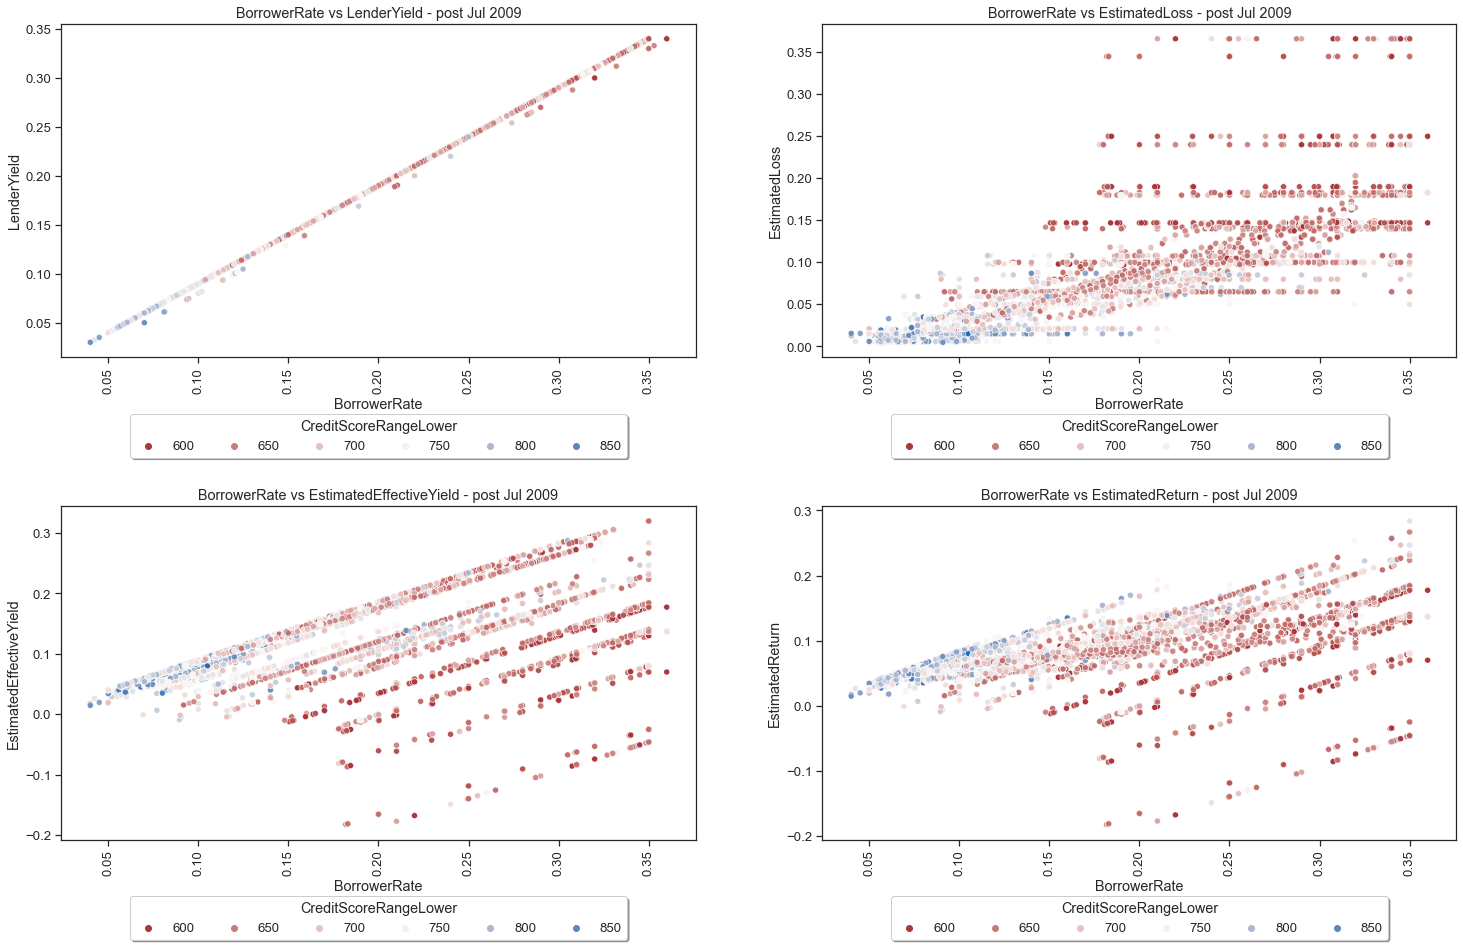

In [60]:
# The relahionship between borrowerRate and EstimateReturn, EstimatedEffectiveYield, and EstimatedLoss shows groups of data points
# What are those groups of data related to?

# lets try to segement the data by CreditScoreRangeLower to see if also has an impact on how those bands are classified using a diverging palette.

# Choosing a divering palette shows the gradual transitions in the scatterplot colours marrying up with the levels present in CreditScoreRangeLower
# for both the horizontal bands and the diagonal swarm of data.

plt.figure(figsize = [25, 15])
plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=0.3, wspace=0.2) #control gap between subplots

# Use white grid plot background from seaborn
sns.set(font_scale=1.2, style="ticks")

plt.subplot(2, 2, 1)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='LenderYield', hue = 'CreditScoreRangeLower', palette="vlag_r")
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs LenderYield - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='LenderYield');
# Shrink current axis's height by 10% on the bottom
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=7, title='CreditScoreRangeLower')

plt.subplot(2, 2, 2)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedLoss', hue = 'CreditScoreRangeLower', palette="vlag_r")
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedLoss - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedLoss');
# Shrink current axis's height by 10% on the bottom
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=7, title='CreditScoreRangeLower')

plt.subplot(2, 2, 3)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedEffectiveYield', hue = 'CreditScoreRangeLower', palette="vlag_r")
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedEffectiveYield - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedEffectiveYield');
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=7, title='CreditScoreRangeLower')

plt.subplot(2, 2, 4)
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna() & dfc_new['EstimatedReturn'].notna()], x='BorrowerRate', y='EstimatedReturn', hue = 'CreditScoreRangeLower', palette="vlag_r")
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerRate vs EstimatedReturn - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedReturn');
box = grid.get_position()
grid.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend below current axis
grid.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=7, title='CreditScoreRangeLower');


## Loan Terms Differences

- 12 and 60 months Term loans form diagonal swarm of data, and therefore are governed by an incremental increase of EstimatedLoss instead of fixed bands of horizontal points.

- 36 months Term loans seem to have both incremental diagonal plot swarm and fixed horizontal plot bands in the EstimatedLoss plot.

- 36 months Term loans have loans with negative EstimatedEffectiveYield and EstimatedReturn whilest 12 and 60 months Term loans have only positive EstimatedEffectiveYield and EstimatedReturn.


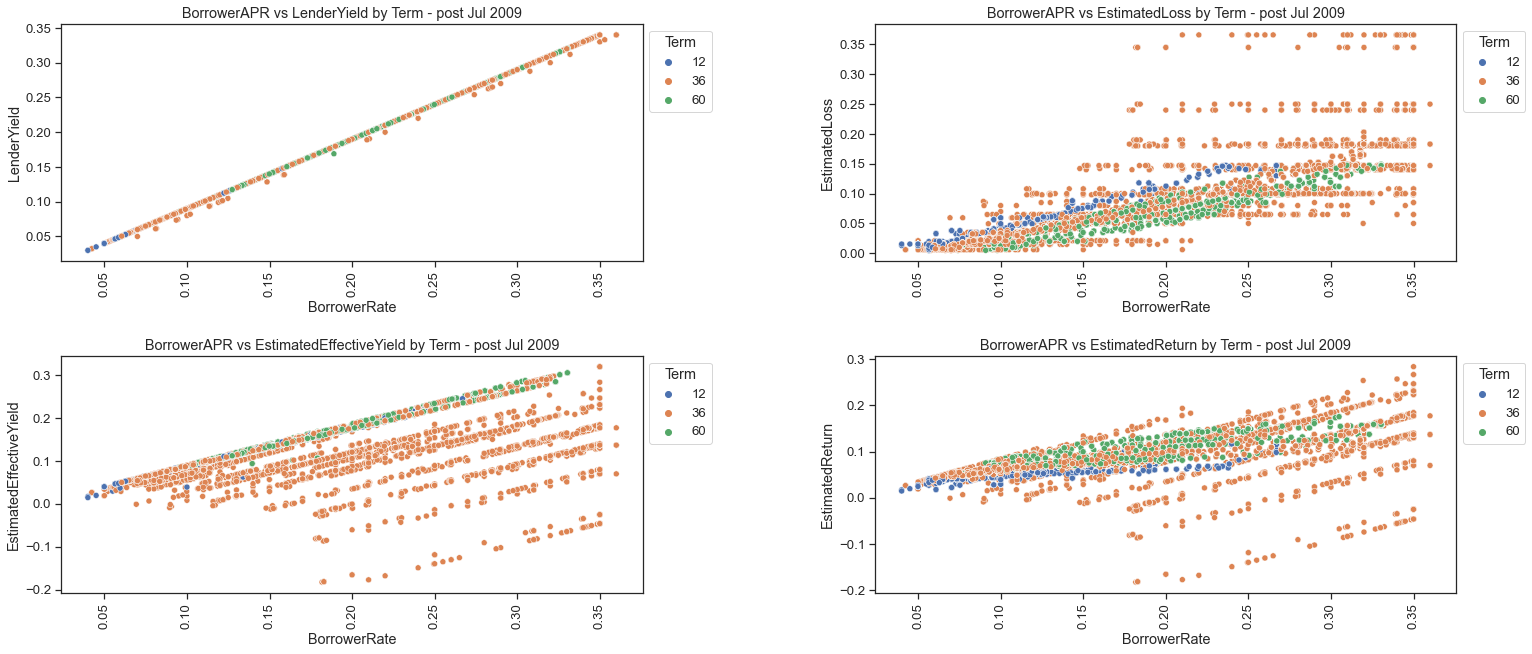

In [61]:
# The relahionship between borrowerRate and EstimateReturn, EstimatedEffectiveYield, and EstimatedLoss shows groups of data points
# What are those groups of data related to?
# lets try to segement the data by Loan Term, which may help explain the different data groupings in the plot.

# The plots shows that some of the variance observed can be explained by the loan Term, 
# The 12 and 60 months Loans have a narrow almost linear spread of points, 
# Whilest the 36 months Term loans have a wide spread with Multiple sub groups of data points.
# The 36 months loans seem to be responsible for the highest loss, and lowest EstimatedReturn and EstimatedEffectiveYield data points compared to the 12 and 60 months Term loans!
# But what are those subgroups? and what other variables can explain the reminder of the variance?

plt.figure(figsize = [25, 10])
plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=0.4, wspace=0.4) #control gap between subplots
palette = sns.color_palette("deep", 3) #Paired

# Use white grid plot background from seaborn
sns.set(font_scale=1.2, style="ticks")

plt.subplot(2, 2, 1)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='LenderYield', hue = 'Term', palette=palette) # , style='LoanStatus'
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerAPR vs LenderYield by Term - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='LenderYield');
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1));

plt.subplot(2, 2, 2)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedLoss', hue = 'Term', palette=palette) # , style='LoanStatus'
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerAPR vs EstimatedLoss by Term - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedLoss');
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1));

plt.subplot(2, 2, 3)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedEffectiveYield', hue = 'Term', palette=palette)
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerAPR vs EstimatedEffectiveYield by Term - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedEffectiveYield');
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1));

plt.subplot(2, 2, 4)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedReturn', hue = 'Term', palette=palette)
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerAPR vs EstimatedReturn by Term - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedReturn');
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1));



## Yealy Differences (I)

- 2009-2010 years are associated with the fixed EstimatedLoss values,that is associated with PropserRating (Alpha) and ProsperScore levels, shown as horizontal bands and rows.

- 2011-2014 years are associated with the incremental EstimatedLoss values,that is associated with PropserRating (Alpha) and ProsperScore levels, shown as diagonal swarm.

- 2009-2010 years have loans with negative EstimatedEffectiveYield and EstimatedReturn, whilest 2011-2014 have loans with only positive EstimatedEffectiveYield and EstimatedReturn.

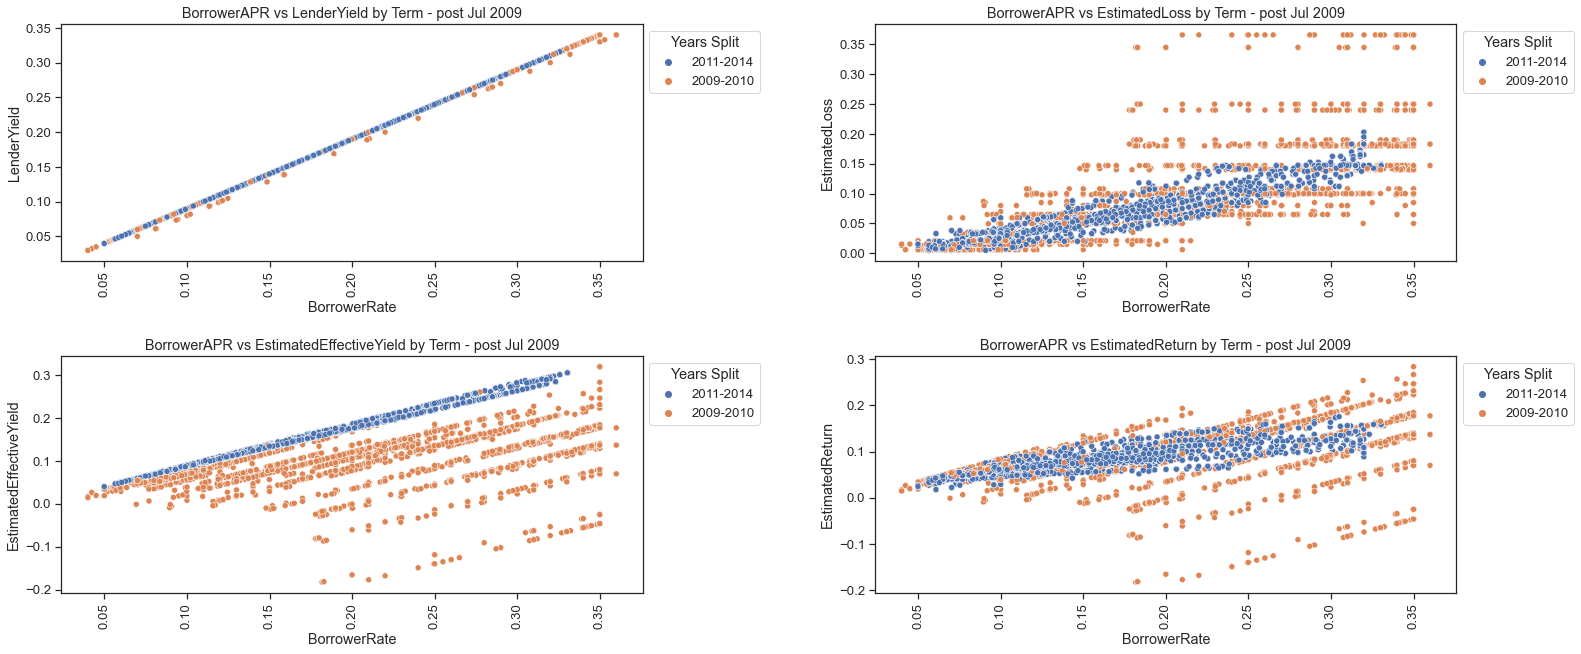

In [46]:
# The relahionship between borrowerRate and EstimateReturn, EstimatedEffectiveYield, and EstimatedLoss shows groups of data points
# What are those groups of data related to?
# lets try to segement the data by Periods, which may help explain the different data groupings in the plot.

# The plots shows that some of the variance observed can be explained by the Periods, 
# The horziontal bands are present in the 2009-2010 period, whiles in the 2011-2014 period it takes a diagonal swarm of data.
# The 2009-2010 have fixed EstimatedLoss values causing those horizontal bands of data to appear. Whereas, 2011-2014 have a incremental EstimatedLoss causing a diagonal swarm of data

plt.figure(figsize = [25, 10])
plt.subplots_adjust(top = 0.8, bottom=0.01, hspace=0.4, wspace=0.4) #control gap between subplots
palette = sns.color_palette("deep", 2) #Paired

# Use white grid plot background from seaborn
sns.set(font_scale=1.2, style="ticks")

plt.subplot(2, 2, 1)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='LenderYield', hue = 'yearSplit', palette=palette) # , style='LoanStatus'
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerAPR vs LenderYield by Term - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='LenderYield')
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1))
grid.legend_.set_title('Years Split');

plt.subplot(2, 2, 2)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedLoss', hue = 'yearSplit', palette=palette) # , style='LoanStatus'
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerAPR vs EstimatedLoss by Term - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedLoss')
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1))
grid.legend_.set_title('Years Split');

plt.subplot(2, 2, 3)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedEffectiveYield', hue = 'yearSplit', palette=palette)
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerAPR vs EstimatedEffectiveYield by Term - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedEffectiveYield')
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1))
grid.legend_.set_title('Years Split');

plt.subplot(2, 2, 4)
#dfc_new['ListingCategory'].value_counts()
grid = sns.scatterplot(data=dfc_new[dfc_new['BorrowerRate'].notna()], x='BorrowerRate', y='EstimatedReturn', hue = 'yearSplit', palette=palette)
grid.tick_params(axis='x', labelrotation=90)
grid.set_title('BorrowerAPR vs EstimatedReturn by Term - post Jul 2009')
grid.set(xlabel='BorrowerRate', ylabel='EstimatedReturn')
sns.move_legend(grid, "upper left", bbox_to_anchor=(1, 1))
grid.legend_.set_title('Years Split');


## Yealy Differences (II)

- Overall, higher BorrowerRate is associated with lower ProsperRating (Alpha) levels.

- Inspecting each year separately shows different characterstics in the EstimatedLoss, EstimatedEffectiveYield, and EstimatedReturn plots.

    - In years 2009 and 2010, EstimatedLoss and EstimatedEffectiveYield values are adjusted to fixed levels according to ProsperRating (Alpha), thus resulting into distinct bands and rows in the plots that contributed to large variance in their values.

    - In years 2011 to 2013 EstimatedLoss and EstimatedEffectiveYield are adjusted to fixed levels according to ProsperRating (Alpha) levels but with much lesser variance, which eliminated negative EstimatedReturn loans.

    - The plots show year 2014 have a perfectly linear BorrowerRate vs EstimatedLoss and EstimatedEffectiveYield plots, where they increased in a linear fashion as ProsperRating (Alpha) worsened with nearly zero variance, which also eliminated negative EstimatedReturn loans. 

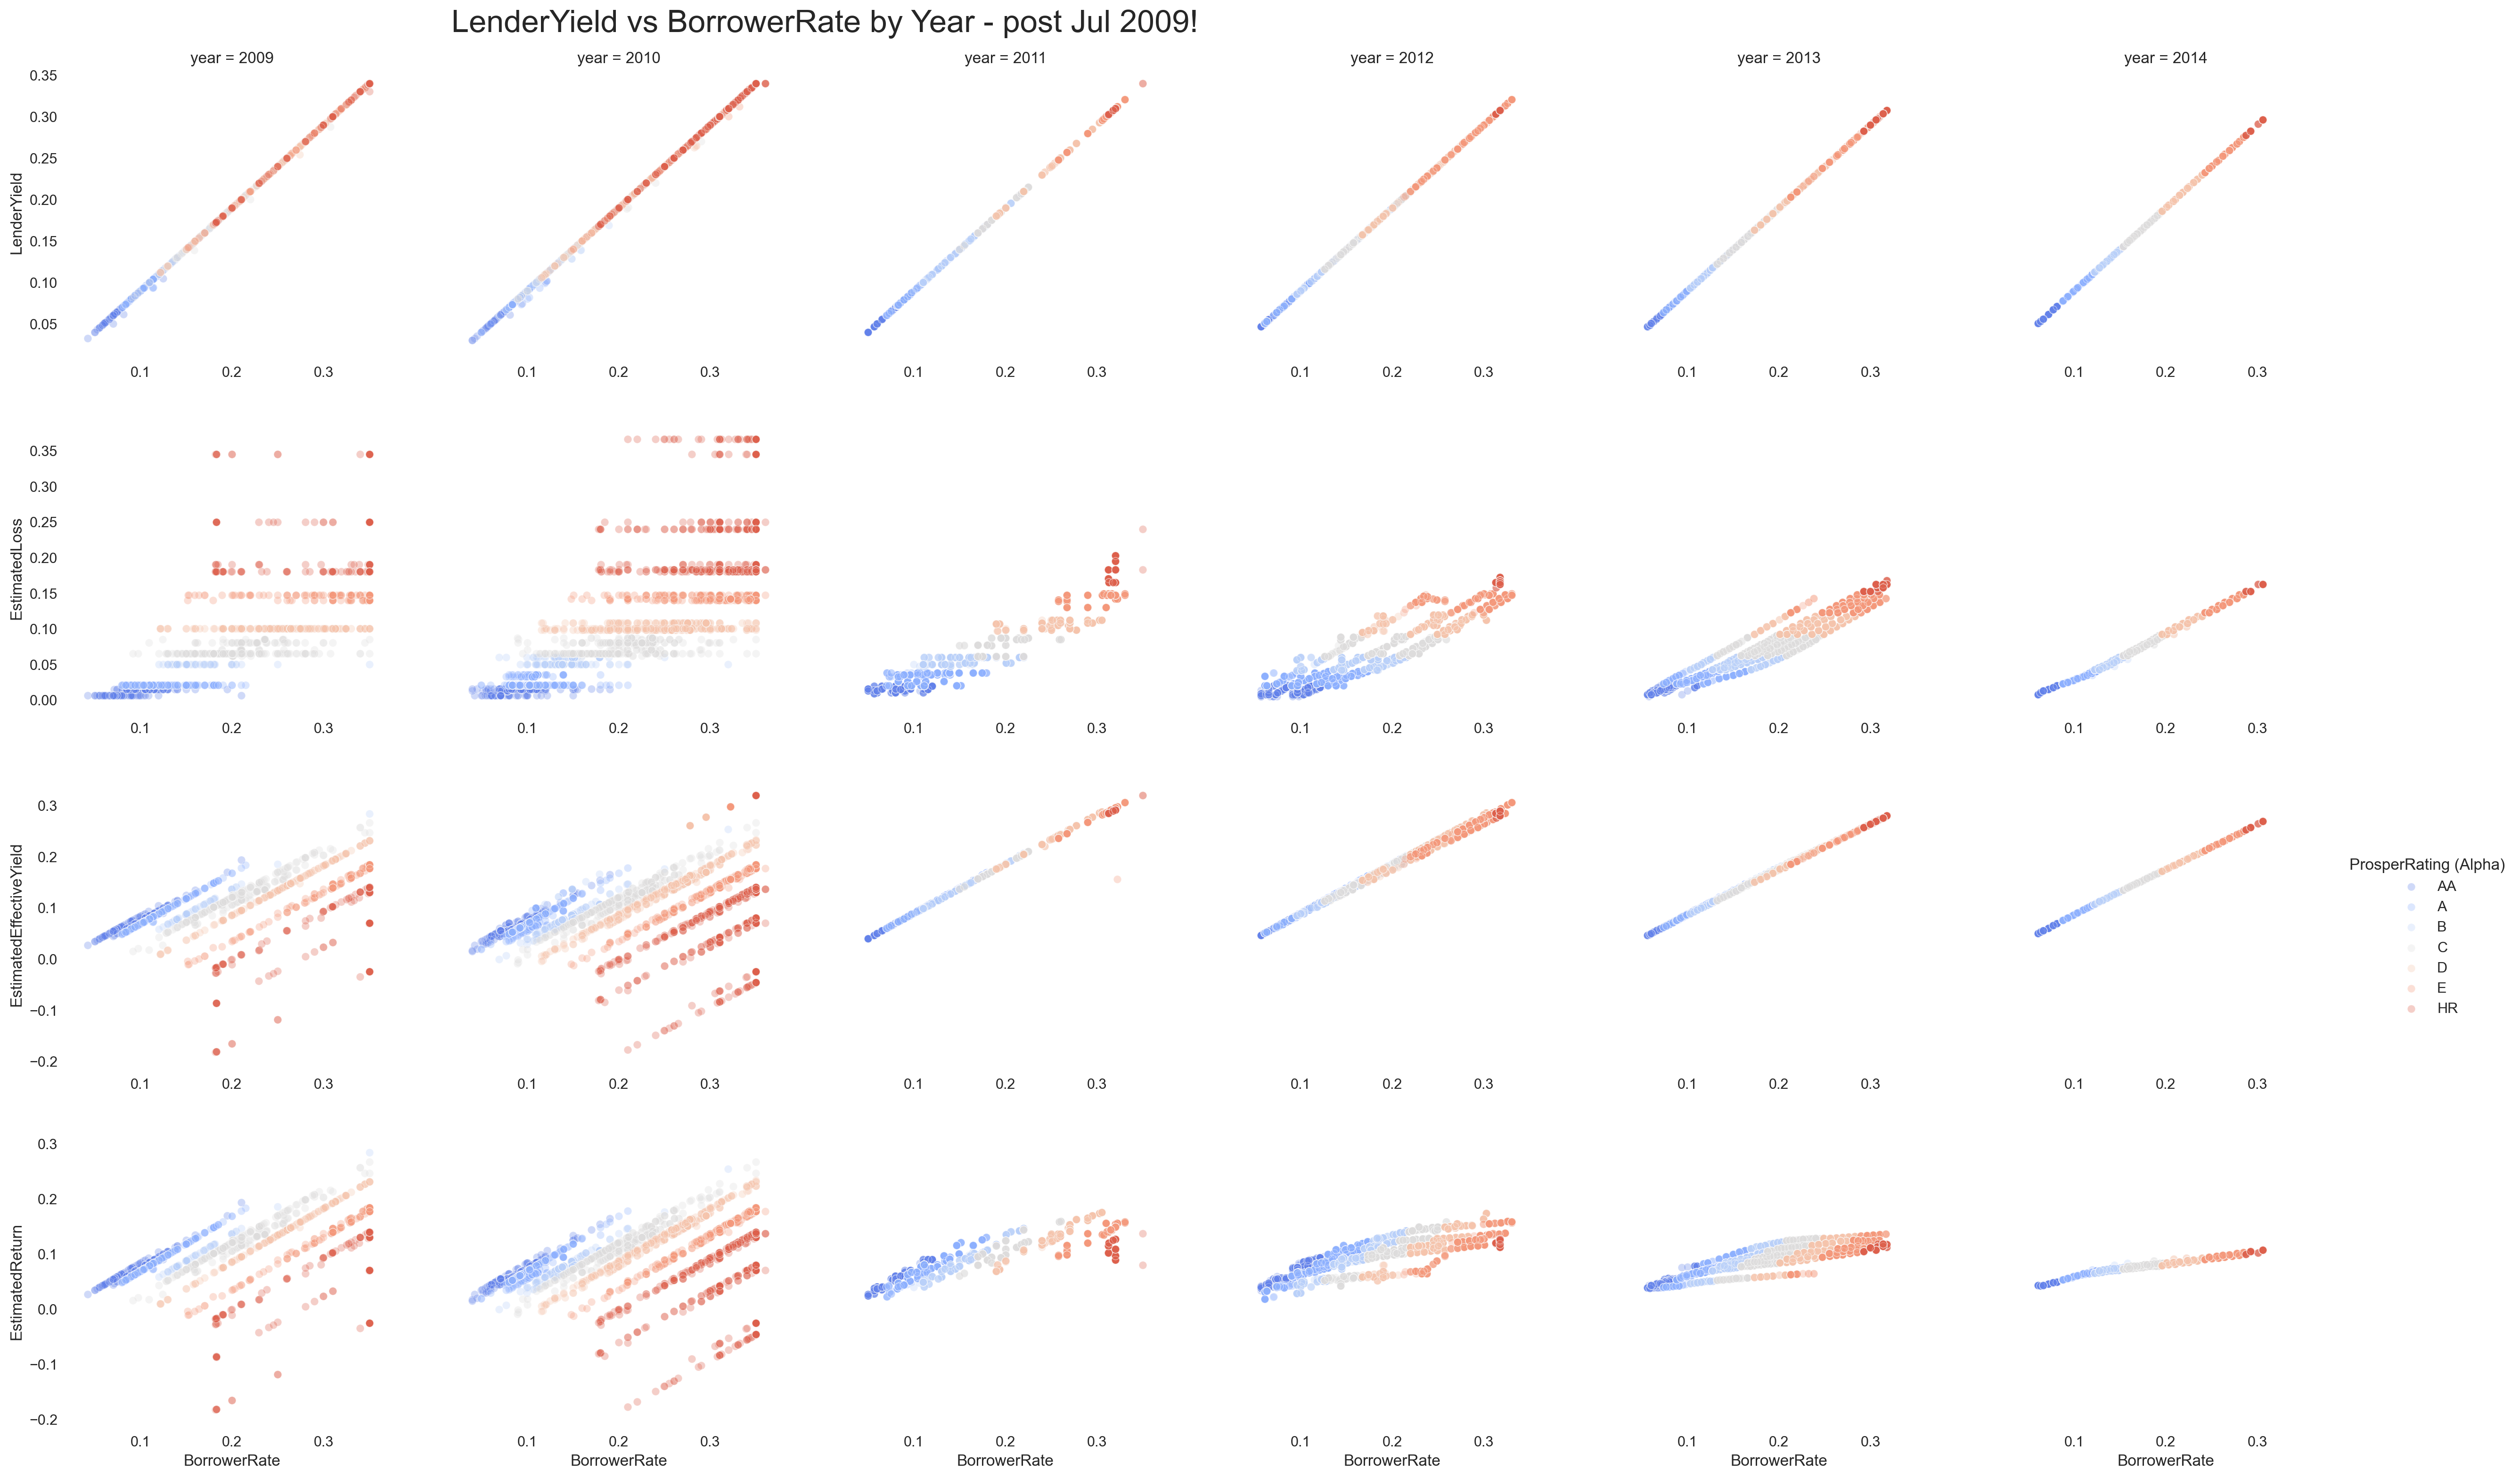

In [64]:
# Faceting the BorrowerRate vs EstimatedLoss relationship by year

# This shows the Estimated Loss different calcualtions changes from fixed bands with very high variance in 2009, and 2010 towards a more linear (small variance) relationship
# in 2011, 2012, 2013 and then finally a nearly perfect linear relationship in 2014.

import patchworklib as pw

pw.overwrite_axisgrid()

sns.set_theme()
sns.set_style("darkgrid")#, {"axes.spines.left": True,'axes.spines.bottom':True}

grid1 = sns.FacetGrid(data=dfc_new, col='year', hue = 'ProsperRating (Alpha)', col_wrap=6, palette="coolwarm", margin_titles=False, height=3, aspect= 1.33)
grid1.map(sns.scatterplot, 'BorrowerRate' , 'LenderYield',  alpha=0.3);
grid1.fig.subplots_adjust(top=0.8)
grid1.fig.suptitle('LenderYield vs BorrowerRate by Year - post Jul 2009!', fontsize=24, x=8, y=15)
grid1.set_axis_labels("", "LenderYield")

grid1 = pw.load_seaborngrid(grid1, label="g1")

grid2 = sns.FacetGrid(data=dfc_new, col='year', hue = 'ProsperRating (Alpha)', col_wrap=6, palette="coolwarm", margin_titles=False, height=3, aspect= 1.33)
grid2.map(sns.scatterplot, 'BorrowerRate' , 'EstimatedLoss',  alpha=0.3);
grid2.set_axis_labels("", "EstimatedLoss")
grid2.set_titles("")
#showsplines(grid2)
grid2 = pw.load_seaborngrid(grid2, label="g2")

grid3 = sns.FacetGrid(data=dfc_new, col='year', hue = 'ProsperRating (Alpha)', col_wrap=6, palette="coolwarm", margin_titles=False, height=3, aspect= 1.33)
grid3.map(sns.scatterplot, 'BorrowerRate' , 'EstimatedEffectiveYield',  alpha=0.3)
grid3.set_axis_labels("", "EstimatedEffectiveYield")
grid3.set_titles("")
grid3.add_legend()
# showsplines(grid3)
grid3 = pw.load_seaborngrid(grid3, label="g3")

grid4 = sns.FacetGrid(data=dfc_new, col='year', hue = 'ProsperRating (Alpha)', col_wrap=6, palette="coolwarm", margin_titles=False, height=3, aspect= 1.33)
grid4.map(sns.scatterplot, 'BorrowerRate' , 'EstimatedReturn',  alpha=0.3);
grid4.set_titles("")
# showsplines(grid4)
grid4 = pw.load_seaborngrid(grid4, label="g4")

sns.set_style("darkgrid")
        
(grid1/grid2/grid3/grid4)


## Avg EstimatedReturn by Year

- The changes observed above seem to have caused loans' EstimatedReturn to reach its highest value (0.125) in the year 2011,

- But it has decreased since then and dropped sharply after 2012 to reach its lowest value in 2014 (0.085).



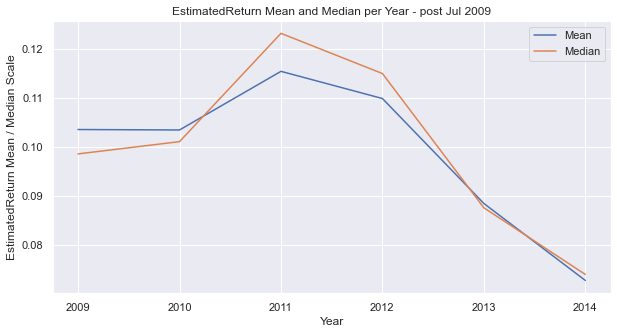

In [65]:
# What is the average EstimatedReturn per year? and does it show any change over time?

# lets plot the above table for visual inspection

# The average EstimatedReturn increased to a peak value of 0.115 in year 2011, but it declined since then to reach 0.072 in 2014.

plt.figure(figsize = [10, 5])

sns.set(font_scale=1) # change plots individual title size.
gmean = sns.lineplot(data=grouped, x="year", y="EstimatedReturn_mean", label = 'Mean')
gmedian = sns.lineplot(data=grouped, x="year", y="EstimatedReturn_median", label = 'Median')
plt.xlabel("Year")
plt.ylabel("EstimatedReturn Mean / Median Scale")
plt.title("EstimatedReturn Mean and Median per Year - post Jul 2009")
plt.legend() # neeeds , label = 'Mean' added to plot code to work!
plt.show();


In [2]:
!jupyter nbconvert Part_II_slide_deck_submit.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Part_II_slide_deck_submit.ipynb to slides
[NbConvertApp] Writing 5534197 bytes to Part_II_slide_deck_submit.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/Part_II_slide_deck_submit.slides.html
Use Control-C to stop this server
^C

Interrupted
